In [35]:
import os
import pandas as pd
import torch
import gc
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from datasets import load_dataset,Dataset
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report
from transformers import AutoTokenizer, PhiForSequenceClassification,AutoModelForCausalLM,AutoModelForSequenceClassification,Trainer, TrainingArguments
from peft import PeftModel, PeftConfig,get_peft_model, LoraConfig, TaskType
from transformers import pipeline
from tqdm import tqdm

## Model Loading
The code initializes a pre-trained language model for causal (generative) language modeling tasks using a specific model checkpoint.

### Model Selection:

A reference to the name of the pre-trained model ("microsoft/phi-2") is stored. This model is known for its language generation capabilities.

###  Tokenizer Initialization:

A tokenizer is loaded from the same pre-trained model. The tokenizer is responsible for converting raw text into tokens (numerical representations) that the model can understand, and vice versa.

###  Model Initialization:

The language model itself is loaded using a causal language modeling architecture.

The model is configured to automatically map its components across available hardware (CPU or GPU) for optimal execution (device_map="auto")

In [2]:
model_name = "microsoft/phi-2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
phi2_base_model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2",device_map="auto")

/home/ubuntu/large_model/lib/python3.12/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Model Loading for classification
This line of code initializes a pre-trained generative language model (microsoft/phi-2) and prepares it for downstream use in a disease classification system.



In [ ]:

#phi2_base_model_classfication = AutoModelForCausalLM.from_pretrained("microsoft/phi-2",device_map="auto")
base_model = PhiForSequenceClassification.from_pretrained(model_name)

In [3]:
gc.collect()

45

## Data Loading
Reading data from a text file using file handling and storing each entry into a list.



In [4]:
lis_cancer=[]
for i in os.listdir("/home/ubuntu/dev_large_model/Cancel_non_Cancer/cancer"):
    with open("/home/ubuntu/dev_large_model/Cancel_non_Cancer/cancer/"+i, "r") as fp:
        fil_read=fp.read()
        lis_cancer.append(fil_read)
lis_non_cancer=[]
for i in os.listdir("/home/ubuntu/dev_large_model/Cancel_non_Cancer/non_cancer"):
    with open("/home/ubuntu/dev_large_model/Cancel_non_Cancer/non_cancer/"+i, "r") as fp:
        fil_read=fp.read()
        lis_non_cancer.append(fil_read)


#list(map(lambda x : x.split(":"), lis_cancer[1].split("\n")[1:]))


## Data Processing
#### Initialize Empty DataFrames

Create two empty data containers df_cancer and df_non_cancer for storing structured cancer and non-cancer records, respectively.

#### Parse and Structure Text Entries

For each text block in lis_cancer and lis_non_cancer:

Skip the first line (usually a header or blank).

Split each remaining line into a key-value pair using ":" as delimiter.

Construct a dictionary from these pairs.

Convert the dictionary into a one-row pandas DataFrame.

Append that row to the respective DataFrame using pd.concat.

#### Clean Index After Each Append (Only for Cancer Data)

For df_cancer, reset the index after each row is appended.

Remove the old index column ('index') created during reset.

#### Select Relevant Fields

Retain only the Title and Abstract fields from both cancer and non-cancer datasets.

#### Add Classification Labels

Add a new column labels:

Set to 'Cancer' for cancer entries.

Set to 'Non Cancer' for non-cancer entries.

#### Normalize Indexes

Reset row indexes for both DataFrames to ensure consistency.

#### Merge Datasets

Combine df_cancer and df_non_cancer into a single DataFrame called diagnostic_df.

#### Rename Columns for Downstream Use

Rename the "Abstract" column to "text" in diagnostic_df, preparing it for tasks like NLP modeling or classification.




In [5]:
df_cancer=pd.DataFrame()
for i in  lis_cancer:
    df=pd.DataFrame.from_dict(dict(map(lambda x: (x.split(":")[0].strip(), " ".join(x.split(":")[1:])), i.split("\n")[1:])),orient='index').T
    df_cancer=pd.concat([df_cancer,df])
    df_cancer=df_cancer.reset_index()
    del df_cancer['index']
df_non_cancer=pd.DataFrame()
for i in  lis_non_cancer:
    df=pd.DataFrame.from_dict(dict(map(lambda x: (x.split(":")[0].strip(), " ".join(x.split(":")[1:])), i.split("\n")[1:])),orient='index').T
    df_non_cancer=pd.concat([df_non_cancer,df])
    #df_non_cancer=df_non_cancer.reset_index()   
    #del df_cancer['index']
    #del df_cancer['index']
df_cancer=df_cancer[['Title','Abstract']]
df_cancer["labels"]='Cancer'
df_non_cancer=df_non_cancer[['Title','Abstract']]
df_non_cancer['labels']='Non Cancer'

In [6]:
df_cancer.reset_index(drop=True,inplace=True)
df_non_cancer.reset_index(drop=True,inplace=True)

In [7]:
diagnostic_df=pd.concat([df_cancer,df_non_cancer]).reset_index(drop=True)

In [8]:
diagnostic_df.columns

Index(['Title', 'Abstract', 'labels'], dtype='object')

In [9]:
diagnostic_df.rename(columns={"Abstract":"text"},inplace=True)

## Train Test Split
Split the train and test with 80 and 20 percent split encode the ground truth </br>
Convert the dataset into huggingface dataset format

In [10]:
train_df, test_df= train_test_split(diagnostic_df, test_size=0.2, random_state=42)


In [11]:
del train_df['Title']

In [12]:
del test_df['Title']

In [13]:
train_df['labels']=train_df['labels'].map({"Cancer":1,"Non Cancer":0})

In [14]:
#test_df['labels']=test_df['labels'].map({"Cancer":1,"Non Cancer":0})

In [14]:
tokenizer.pad_token = tokenizer.eos_token


In [15]:

train_dataset = Dataset.from_pandas(train_df,split="train")

In [16]:
test_dataset = Dataset.from_pandas(test_df,split="test")

In [17]:

os.environ["TOKENIZERS_PARALLELISM"] = "false"


### Remove irrelevant Cache from RAM and GPU

In [22]:
torch.cuda.empty_cache()
gc.collect()

2395

In [22]:
train_dataset

Dataset({
    features: ['text', 'labels'],
    num_rows: 800
})

## Classification Head addition in the architectecture 

I wrap this expert with a new layer that acts like a decision maker
This new decision maker listens to the experts final thoughts last layer hidden states and then decides if the case is cancer or non cancer
This is done by a linear layer classifier that maps the understanding into two possible outcomes Cancer or Non Cancer
<ul><li>Model Architecture PhiForClassification</li>
The model starts with a pretrained expert base model such as Phi2 who understands medical language
On top of that we add a yes or no classification layer that turns understanding into a diagnostic decision cancer vs non cancer

<li>Forward Process</li>
The model reads patient records using input IDs and attention mask
It extracts the deepest insight from the last token like the experts final conclusion
This insight is passed to the classifier which makes the final predictio


In [ ]:
# Step 2: Wrap with Classification Head
class PhiForClassification(nn.Module):
    def __init__(self, base_model, num_labels):
        super().__init__()
        self.backbone = base_model
        self.config = base_model.caonfig  
        self.classifier = nn.Linear(base_model.config.hidden_size, num_labels)

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        kwargs["output_hidden_states"] = True

        outputs = self.backbone(
            input_ids=input_ids,
            attention_mask=attention_mask,
            #output_hidden_states=True,
             **kwargs
        )
        hidden_state = outputs.hidden_states[-1]  # shape: (batch, seq_len, hidden)
        pooled = hidden_state[:, -1, :]  # last token
        logits = self.classifier(pooled)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        return {"loss": loss, "logits": logits} if loss is not None else {"logits": logits}
# Wrap base model
model = PhiForClassification(base_model, num_labels=2)  # change num_labels as needed


## LoRA Configuration :

Specifies how low-rank adapters should be injected into the model.

r=5: Sets the rank (size) of the adapter matrices — smaller means fewer trainable parameters.

lora_alpha=16: A scaling factor that influences the strength of the adapter’s update.

lora_dropout=0.05: Applies dropout to the adapter during training for regularization.

target_modules=["k_proj", "v_proj"]: LoRA is only applied to key and value projection layers in the attention mechanism.

task_type=TaskType.SEQ_CLS: Indicates the model is being fine-tuned for a sequence classification task.



In [ ]:

lora_config = LoraConfig(
    r=5,
    lora_alpha=16,
    lora_dropout=0.05,
    #target_modules=["q_proj", "k_proj", "v_proj"],
    target_modules=[ "k_proj", "v_proj"],
    task_type=TaskType.SEQ_CLS
)
model = get_peft_model(model, lora_config)
model = model.to(torch.float32)

## Define a preprocessing function:

tokenizer(...): Converts raw text (example["text"]) into token IDs using a pre-trained tokenizer.

padding="max_length": Ensures all tokenized sequences are padded to the same length (here, 250 tokens).

truncation=True: Trims texts longer than the max length to avoid overflow.

max_length=250: Sets a fixed sequence length for all inputs.

enc["labels"] = example["labels"]: Assigns the correct class label for training (e.g., cancer vs non-cancer).

Apply preprocessing to the dataset:

dataset.map(preprocess): Efficiently transforms the entire dataset by applying the preprocess function to each text into token.



In [ ]:

def preprocess(example):
    enc = tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=250
    )
    enc["labels"] = example["labels"]
    return enc

dataset = train_dataset#Dataset.from_list(examples)
dataset = dataset.map(preprocess)

## Training setup
<b>Temporal Scope:</b>
The system will experience 3 full exposures (num_train_epochs) to the training environment (dataset), reinforcing its understanding over time.

<b>Load Management:</b>
The system will process 1 unit of experience per interaction (per_device_train_batch_size=1) but will accumulate gradients over 8 such steps (gradient_accumulation_steps=8) before updating itself — simulating a delayed learning reflection.

<b>Precision of Thought:</b>
fp16=False, bf16=False: The system will work in full precision (float32), prioritizing numerical stability over efficiency, avoiding compressed or lossy computation.



In [ ]:

training_args = TrainingArguments(
    output_dir="phi2_cls",
    per_device_train_batch_size=1,
    num_train_epochs=3,
    gradient_accumulation_steps=8,
    logging_steps=10,
    fp16=False,
    save_steps=50,
    report_to="none",
    #per_device_train_batch_size=4,
    #gradient_accumulation_steps=4,
    #fp16=False,            # <- critical to disable half precision
    bf16=False            # <- also off if on A100

    
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    tokenizer=tokenizer
#    fp16=False,  # <- important

)

In [ ]:
# Step 6: Train
trainer.train()


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers and GPU quantization are unavailable.


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipykernel_2839/4273494465.py:95: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
10,0.678800
20,0.826900
30,0.738000
40,0.750200
50,0.678200
60,0.630300
70,0.672900
80,0.712600
90,0.638800
100,0.657000


## Loading model from check points
Specifies the path to the saved fine-tuned model checkpoint, representing the model state after 300 steps of training.

base_model = PhiForSequenceClassification.from_pretrained(model_name)

Loads a pre-trained Phi model adapted for sequence classification tasks, using weights from a base model_name.

model = PeftModel.from_pretrained(base_model, checkpoint_path)

Wraps the base model with PEFT (Parameter-Efficient Fine-Tuning) logic.

Injects LoRA-adapted weights from the saved checkpoint, enabling task-specific adaptation without updating all base model parameters.

tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)

Loads the tokenizer configuration (vocab, special tokens, etc.) from the same checkpoint, ensuring alignment with how the model was trained.

tokenizer.pad_token = tokenizer.eos_token

Sets the padding token to the end-of-sequence token, a workaround often used with decoder-only language models lacking a native pad token.



In [19]:
from tqdm import tqdm


In [23]:
checkpoint_path = "./phi2_cls/checkpoint-300"
base_model = PhiForSequenceClassification.from_pretrained(model_name)
model = PeftModel.from_pretrained(base_model, checkpoint_path)
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
tokenizer.pad_token = tokenizer.eos_token



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of PhiForSequenceClassification were not initialized from the model checkpoint at microsoft/phi-2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers and GPU quantization are unavailable.


## Baseline model Pipeline Defination
pipeline("text-classification", ...)

Instantiates a high-level inference wrapper for performing sequence-level classification tasks (e.g., sentiment analysis, spam detection, topic classification).

model=base_model

Uses the base language model, adapted for classification, to compute output logits for each input text sequence.

tokenizer=tokenizer

Applies the text-to-token transformation consistent with the model’s training, including tokenization, truncation, and padding.

return_all_scores=True

Ensures the pipeline returns softmax-normalized scores (probabilities) for all possible classes, not just the highest-scoring one.



In [24]:
clf_pipeline_baseline = pipeline("text-classification",model=base_model,tokenizer=tokenizer,return_all_scores=True)

Device set to use cpu


### Base Model Inferncing
baseline_output = []

Initializes an empty list to accumulate model predictions for each input text.

This acts as the container for output scores from the classification process.

for abstract_text in tqdm(test_dataset['text']):

Iterates over each text instance in the test dataset, specifically from the "text" field.

tqdm is used for tracking the progress of the loop via a progress bar — helpful for long-running inferences.

result = clf_pipeline_baseline(abstract_text)

Feeds each text into a Transformer pipeline configured for text classification.

Internally, this applies tokenization, passes the data through the model, and computes class probabilities.

The return_all_scores=True setting ensures that the model outputs the full distribution of scores across all classes.

baseline_output.append(result)



In [30]:
dict_map2={1:"Cancer",0:"Non Cancer"}
dict_map={"LABEL_1":"Cancer","LABEL_0":"Non Cancer"}

In [25]:
baseline_output=[]
for abstract_text in tqdm(test_dataset['text']):
    result=clf_pipeline_baseline(f"Categorize the text cancer vs non cancer classes {abstract_text}")
    baseline_output.append(result)

100%|███████████████████████████████████████| 200/200 [1:09:22<00:00, 20.81s/it]


In [28]:
baseline_output[1]

[[{'label': 'LABEL_0', 'score': 0.36464840173721313},
  {'label': 'LABEL_1', 'score': 0.6353515982627869}]]

In [29]:
output_baseline_result=[max(i[0], key=lambda d: d['score'])  for i in baseline_output]

In [54]:
output_baseline_result[1]

{'label': 'LABEL_1', 'score': 0.6353515982627869}

In [31]:
output_baseline_model_res=[{"label":dict_map[i['label']],"score":i['score']} for i in output_baseline_result]

## Baseline Model Evaluation


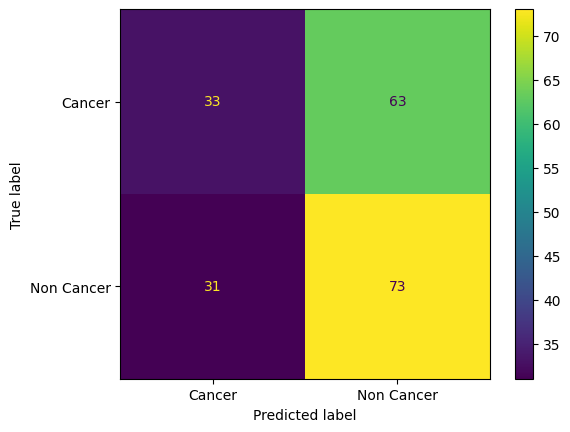

In [36]:
conf=confusion_matrix(test_dataset['labels'],[i["label"] for i in output_baseline_model_res],labels=['Cancer','Non Cancer'])
disp = ConfusionMatrixDisplay(confusion_matrix=conf,display_labels=['Cancer','Non Cancer'])
disp.plot()

### Baseline Model Classification

In [37]:
print(classification_report(test_dataset['labels'],[i["label"] for i in output_baseline_model_res]))

              precision    recall  f1-score   support

      Cancer       0.52      0.34      0.41        96
  Non Cancer       0.54      0.70      0.61       104

    accuracy                           0.53       200
   macro avg       0.53      0.52      0.51       200
weighted avg       0.53      0.53      0.51       200



## Inferencing Pipeline for Fine Tuned Model
<b>Pipeline Initialization:</b>

Creates a text classification inference pipeline using the Hugging Face transformers.pipeline utility.

This abstracts away preprocessing (tokenization), model forwarding, and postprocessing (softmax, label mapping).

<b>Fine-tuned Model:</b>

The model passed here is a fine-tuned transformer-based model, likely adapted for a domain-specific binary classification task (e.g., cancer vs. non-cancer).

The model weights reflect task-specific knowledge learned during supervised fine-tuning.

<b>Tokenizer Integration:</b>

The tokenizer is coupled with the model to ensure consistent text-to-token transformations, which include padding, truncation, and vocabulary mapping.

<b>All Class Probabilities:</b>

return_all_scores=True instructs the pipeline to return the full probability distribution (e.g., logits or softmax scores) for all classes instead of just the top prediction.

This is useful for confidence estimation, threshold tuning, and multi-class/multi-label settings.



In [25]:
clf_pipeline = pipeline("text-classification",model=model,tokenizer=tokenizer,return_all_scores=True  )

The model 'PeftModelForSequenceClassification' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForSequenceClassification', 'ErnieForSequenceClassification', 'ErnieMForSequenceClassification', 'EsmForSequenceClassification', 'FalconForSequenceClassification', 'FlaubertForSequenceClassification', 'FNetForSequenceClassification', 'FunnelForSequenceClassification', 'GemmaForSequenceClassification'

### Fine Tuned Model Inferncing

<b>Prediction Loop Over Test Set:</b>
Iterates over each sample (e.g., clinical abstract, document, or input text) in the test dataset to generate predictions from the model.

<b>Inference Using Classification Pipeline:</b>
For each input text, the clf_pipeline_baseline (which wraps the fine-tuned model and tokenizer) is invoked. This handles:

Tokenization of the raw text,

Model forward pass to generate logits,

Softmax activation and

Label mapping.

<b>Progress Monitoring:</b>
The loop is wrapped with tqdm, a utility that provides a real-time progress bar, helping monitor the inference step during large-scale evaluation.

<b>Score Aggregation:</b>
The prediction result (typically class probabilities or logits) is appended to a list, baseline_output, which accumulates the model's outputs for the full test set. This list will later be used for performance evaluation (e.g., classification report, confusion matrix).



In [26]:

output=[]
for abstract_text in tqdm(test_dataset['text']):
    result=clf_pipeline(abstract_text)
    output.append(result)

100%|███████████████████████████████████████| 200/200 [1:06:50<00:00, 20.05s/it]


## Decoding the output
1. Extracting the max score label
2. Mapping it into original label

In [50]:
output[0]

[[{'label': 'LABEL_0', 'score': 0.83}, {'label': 'LABEL_1', 'score': 0.17}]]

In [52]:
output_rest=[max(i[0], key=lambda d: d['score'])  for i in output]
output2_res=[{"label":dict_map[i['label']],"score":i['score']} for i in output_rest]

In [53]:
output2_res[0]

{'label': 'Non Cancer', 'score': 0.83}

### Fine Tuned Model Evaluation

In [22]:
conf=confusion_matrix(test_dataset['labels'],[i["label"] for i in output2_res],labels=['Cancer','Non Cancer'])

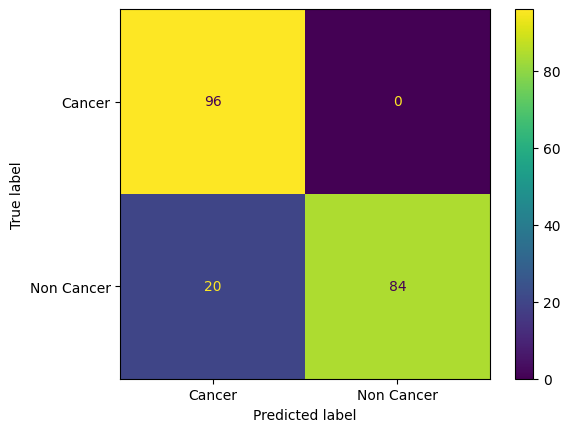

In [23]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf,display_labels=['Cancer','Non Cancer'])
disp.plot()

### Classification Report For Finetune model
This is a classification report summarizing the performance of a binary classifier on a test set of 200 examples (96 Cancer, 104 Non Cancer). Each metric is computed per class and globally.</br>
<b>Precision:<b>

<b>Cancer: </b>When the model predicts "Cancer", it’s correct 83% of the time.

<b>Non Cancer:</b> When it predicts "Non Cancer", it’s correct 100% of the time.

<b>Recall:</b>

<b>Cancer: </b>The model finds all actual Cancer cases (100% recall).

<b>Non Cancer:</b> It finds 81% of the actual Non Cancer cases; it misses 19%.

<b>F1-Score:</b>

The harmonic mean of precision and recall.

Balanced performance: 0.91 for Cancer and 0.89 for Non Cancer.

<b>Support:</b>

Number of true instances per class in the test set.




In [24]:
print(classification_report(test_dataset['labels'],[i["label"] for i in output2_res]))

              precision    recall  f1-score   support

      Cancer       0.83      1.00      0.91        96
  Non Cancer       1.00      0.81      0.89       104

    accuracy                           0.90       200
   macro avg       0.91      0.90      0.90       200
weighted avg       0.92      0.90      0.90       200



In [19]:
disease_extraction = pipeline("text-generation",model=phi2_base_model,tokenizer=tokenizer,max_new_tokens=10,temperature=0.0,  do_sample=False ,return_full_text=False)

Device set to use cpu
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [20]:
import warnings
warnings.filterwarnings('ignore')


## Disease Name Extraction using Baseline Model
This pipeline enables automated knowledge extraction of disease mentions from raw medical text using a prompt-driven inference mechanism — facilitating downstream tasks like classification, ontology linking, or structured reporting.

<b>Iterative Semantic Extraction:</b>
The loop iterates over each text instance in the test dataset (e.g., biomedical abstracts or clinical notes) to semantically extract information.

<b>Prompt-based Querying:</b>
For each text sample, a prompt is dynamically constructed — asking the model to "Explain the disease name only from the abstract."
This likely leverages a language model or prompt-based pipeline that can perform open-ended extraction (e.g., GPT, T5, or FLAN-T5 variants).

<b>Text-to-Entity Conversion:</b>
The function disease_extraction(...) acts as a semantic interpreter, transforming unstructured text into a structured entity: the disease name.
Internally, this may involve text generation, NER, or span extraction depending on the model.

<b>Result Aggregation:</b>
Each extracted disease name (or phrase) is appended to disease_list, building a collection of disease entities for the entire dataset.



In [21]:
disease_list=[]
for abstract_extract in  tqdm(test_dataset['text']):
    disease_extract = disease_extraction(f"Explain the disease name only from the abstract text {abstract_extract}")
    disease_list.append(disease_extract)

100%|███████████████████████████████████████| 200/200 [1:36:26<00:00, 28.93s/it]


In [46]:
## Output Processing
disease_list_proceed=[i[0]['generated_text'].replace("Answer","").replace("Keywords","") for i in disease_list]

[' The missense mutation of exons 11 and 35',
 '\n\n- Pyrocarbon\n- Fib',
 '  \n\n: The disease name is breast',
 ' XL019 was well tolerated and demonstrated activity in patients',
 '\n: Lung cancer; Non-small',
 ' The cervical spine was stable and the patient was free',
 '\nThe study was performed in a cohort of patients',
 ' We aimed to identify the prevalence of SFTPC',
 '\n: Lichen planus, mast',
 '\n: Familial adenomat',
 '\nA case of Erdheim-Chester disease',
 '\nAB - BACKGROUND  MYCN amplification (',
 ' The phantom is composed of a 3D model of',
 '\n: COVID-19, S',
 '\nAB - CONTEXT  Inactivating germ',
 '\nAgo2-mediated RNA silencing regulates',
 '  \n\nSolution:\n\n```python',
 '\nAB - BACKGROUND  The mechanisms by which',
 '\nThe aim of this study was to investigate the',
 '\n: circulating miRNAs, EG',
 '\n\n##Your task: **Rewrite**',
 ' PMID:26378862\nABSTR',
 '\n: Lung cancer; Radiomics',
 '\nAB - BACKGROUND  Thrombop',
 ' The treatment of pituitary adenomas is',
 '\n: Colo